# Ray and OpticalSystem

In this object-oriented two-dimensional ray tracing approach, `Ray` objects have an `origin`, `direction`, and `power`, and are traced through various optical elements managed by an `OpticalSystem` object. Rays are terminated if they reach the system's boundary --- a rectangle defined by the `extent=[xmin, xmax, ymin, ymax]` argument. Once traced, a ray object gains the `points` attribute corresponding to the points of intersection with various optical elements or system boundaries. Additionally, the `optical_path_length` attribute provides the total geometric distance traveled traveled times the environemental refractive index (fixed as a global constant `n0=1` in the `ray_trace.py` module).

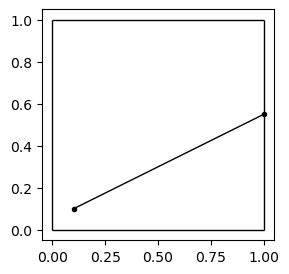

In [1]:
from ray_trace import Ray, OpticalSystem
import matplotlib.pyplot as plt
import numpy as np

# Default domain is the unit square.
sys = OpticalSystem() 
# Direction is internally normalized. Default power is 1. 
ray = Ray(origin=[0.1, 0.1], direction=[2, 1]) 
# Trace the ray
sys.trace(ray)

#Plot the result
fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
ray.plot(ax, marker=".", color="k", lw=1)

# Expect that the ray travels from its origin along its direction 
# until reaching the boundary, in this case at x=1:
# y(x) = 0.1 + (x-0.1)/2, so y(1) = 0.55
# opl = 1 * sqrt((0.55 - 0.1)^2 + (1 - 0.1)^2) = 1.0062
assert np.allclose(ray.points, 
                   np.array([[0.1, 0.1 ], 
                             [1.0, 0.55]])
                  )
assert ray.optical_path_length == 1.0062305898749053

# Mirror

The `Mirror` object implements the law of reflection for rays. A mirror is defined by its length, center point, and an angle (in radians) between the x-axis and mirror surface.

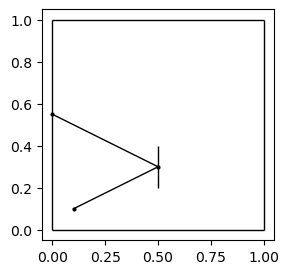

In [2]:
from ray_trace import Ray, Mirror, OpticalSystem
import matplotlib.pyplot as plt
import numpy as np

sys = OpticalSystem() 
mirror = Mirror(length=0.2, center=[0.5, 0.3], angle=np.pi/2)
ray = Ray(origin=[0.1, 0.1], direction=[2, 1])

sys.add_element(mirror)
sys.trace(ray)

fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
ray.plot(ax, marker=".", color="k", lw=1, ms=4)

# Expect that the ray travels to the mirror, reflects along the 
# x-axis, then termenates when it reaches the x=0 boundary.
# Therefore, the optical path length and final y-coordinate are 
#the same as the previous example while the final x-coordinate is 0.
assert np.allclose(ray.points, 
                   np.array([[0.1, 0.1 ],
                             [0.5, 0.3 ],
                             [0.0, 0.55]])
                  )
assert ray.optical_path_length == 1.0062305898749053

# GaussianBundle

Tracing one ray is hardly interesting. The `GaussianBundle` class provides a convenient way to initialize and track many rays with a gaussian power profile. The bundle is defined by its gaussian radius (waist), its `center` point, `direction`, `number` of rays, and `total_power` (default is 1). Rays originate from a 4-waist width and by default are dithered (randomized along the starting plane), by 1% of the width. The function `trace_bundle` is defined outside the scope of the `OpticalSystem` class for parallelized ray tracing.

Traced 50 rays in 1.09 s using 32 cores


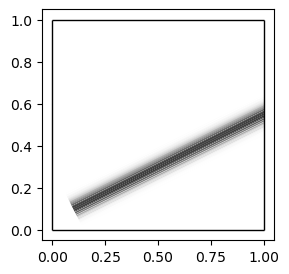

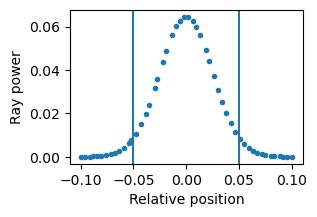

In [3]:
from ray_trace import GaussianBundle, OpticalSystem, trace_bundle
import matplotlib.pyplot as plt
import numpy as np
sys = OpticalSystem()
bundle = GaussianBundle(waist=0.05, 
                        center=[0.1, 0.1], 
                        number = 50,
                        direction=[2,1], 
                        dither=True)


# Each ray is independent, so they may be easily traced in parallel.
# The load ballance is attempted by defalut using all available 
# cores and splitting the rays equally among them.
# This is probably not optimal especially if number <~ 100.
# Use n_jobs and n_rays_per_job for finer control. If n_jobs=-1, all
# cores are used, n_jobs=-2, all cores except 1 are used, and so on.
trace_bundle(sys, bundle)

# To plot a bundle, we plot each ray with an 
# opacity proportional to its power
fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
bundle.plot(ax, color="k", lw=0.5, ms=4)
plt.show()

# Expect a gaussan profile on the line tangent to bundle direction
fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(bundle.relative_origins, bundle.powers, 
         marker=".", ls="none")
plt.axvline(-bundle.waist)
plt.axvline(+bundle.waist)
plt.ylabel("Ray power")
plt.xlabel("Relative position")

# Expect the specified total power
assert np.allclose(sum(bundle.powers), bundle.total_power)

# BiconvexLens

 `BiconvexLens` is a class for simulating a thick lens with two convex radii of curvature. Since the class is specific to biconvex lenses, we define all radii of curvature to be positive. A lens is specified by its `radius1`, `radius2`, `thickness`, refractive `index`, `center`, and , `angle`. Thick lens formulae are used to fill out attributes `focal_length`, `principal_plane1`, and `principal_plane2`. The factory function `make_lens` finds radius=radius1=radius2 and thickness such that the resulting focal length is near a given `target_focal_length`. That lens object can then be placed and oriented using the class method `position`. 

Traced 5 rays in 0.037 s using 32 cores


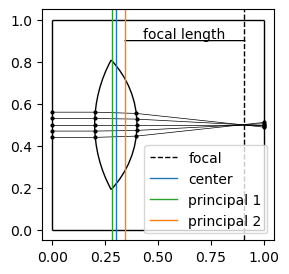

In [4]:
from ray_trace import BiconvexLens, GaussianBundle, OpticalSystem, trace_bundle
import matplotlib.pyplot as plt

sys = OpticalSystem()
lens = BiconvexLens(radius1=0.65, 
                    radius2=0.45, 
                    thickness=0.2, 
                    index=1.5, 
                    center=[0.3, 0.5], 
                    angle=0)
bundle = GaussianBundle(waist=0.03, 
                        center=[0.0, 0.5], 
                        number = 5,
                        direction=[1,0], 
                        dither=False)

sys.add_element(lens)
trace_bundle(sys, bundle)

# Expect parallel rays to come to a focus (up to spherical aberations)
# at one focal length away from the principal plane defined by the 
# enterance surface
relative_p2 = lens.thickness/2 - lens.principal_plane2
relative_p1 = -lens.thickness/2 + lens.principal_plane1
focal_plane = lens.center[0] + relative_p2 + lens.focal_length

fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
bundle.plot(ax, color="k", marker=".", alpha=1, lw=0.5, ms=4)

ax.axvline(focal_plane, lw=1, c="k", ls="--", label="focal")
ax.axvline(lens.center[0], c="C0", lw=1, label="center")
ax.axvline(lens.center[0]+relative_p1,
           c="C2",lw=1, label="principal 1")
ax.axvline(lens.center[0]+relative_p2,
           c="C1",lw=1, label="principal 2")
ax.text(lens.center[0]+relative_p2+lens.focal_length/2, 0.9, "focal length",
       ha="center", va="bottom")
ax.arrow(lens.center[0]+relative_p2, 
         0.9, lens.focal_length, 0, lw=0.5)
ax.legend()
plt.show()

Traced 5 rays in 0.046 s using 32 cores


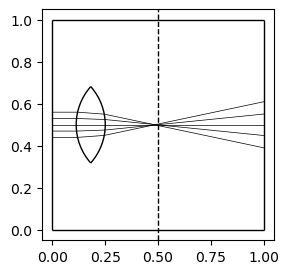

In [5]:
from ray_trace import make_lens, GaussianBundle, OpticalSystem, trace_bundle
import matplotlib.pyplot as plt

sys = OpticalSystem()
lens = make_lens(target_focal_length=0.3, 
                 approximate_thickness=0.15, 
                 index=1.5)
cx = 0.2-lens.thickness/2+lens.principal_plane2
lens.position(center=[cx, 0.5],
              angle=0)
bundle = GaussianBundle(waist=0.03, 
                        center=[0.0, 0.5], 
                        number = 5,
                        direction=[1,0], 
                        dither=False)

sys.add_element(lens)
trace_bundle(sys, bundle)
focal_plane = lens.center[0] + lens.thickness/2 - lens.principal_plane2 + lens.focal_length


# We created a lens with focal length 0.3 and positioned it's 
# second principal plane at (0.2, 0.5). Expect the ray bundle to 
#focus to the center of the domain (0.5, 0.5),

fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
bundle.plot(ax, color="k", alpha=1, lw=0.5, ms=4)

ax.axvline(focal_plane, lw=1, c="k", ls="--", label="focal")
plt.show()

# GradientIndexRegion

The `GradientIndexRegion` class integrates the Eikonal equation to trace rays through continuously-varying refractive index media (i.e., _gradient index_ or GRIN media). GRIN media are used for certain lens designes, in models of light propagation through the atmosphere or through acoustic/thermal perturbations. The functionalty here is restricted to a rectangular region sparated from all other optical elements of the system. The region is specified by its `meshspec=[[xmin, xmax, mx],[ymin, ymax, my]]`, where `mx` and `my` specify the the number of points along each axis used to grid the region (default) or the step size of the grid along each axis (if `spec='delta'` is passed). A `GradientIndexRegion` is further specified by its Runge-Kutta-3 `step_size`, and a function `index_func` with signature `index_func(point: array([x: float, y:float])) -> float` that specifies the refractive index at a given point. Given only the above, inputs, the region will compute the finite-difference approximation to the gradient of `index_func` of the grid defined by `meshspec` and construct interpolating functions for use in ray tracing. Alternativly, the gradient can be specified directly for enhanced efficency and accuracy by passing the `grad_index_func` argument with signiture `grad_index_func(point: array([x: float, y:float])) -> array([u: float, v:float]`. When `grad_index_func` the `meshspec` grid is only used for plotting purposes. 

Traced 10 rays in 0.052 s using 1 cores


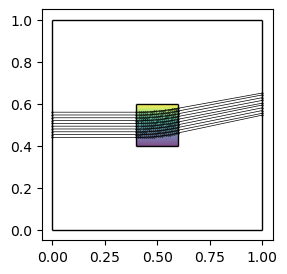

In [6]:
from ray_trace import GradientIndexRegion, GaussianBundle, OpticalSystem, trace_bundle
import matplotlib.pyplot as plt
import numpy as np

sys = OpticalSystem()
# NOTE: Any required libraries must be imported within defintion
# This is a quirk of the parallelization using joblib.
def index_func(point):
    import numpy as np
    return 1.0 + np.array([0.0, 1.0]) @ (point - np.array([0.5, 0.5]))

grin = GradientIndexRegion(index_func=index_func,
                           step_size=0.01,
                           meshspec=[[0.4, 0.6, 100],[0.4, 0.6, 100]])
bundle = GaussianBundle(waist=0.03, 
                        center=[0.0, 0.5], 
                        number = 10,
                        direction=[1.0, 0.0], 
                        dither=False)

sys.add_element(grin)
trace_bundle(sys, bundle, n_jobs=1)

# We have lanched horizontal rays through a medium with a constant
# index gradient in the vertical direction. Expect rays are bent 
#up the gradient.
fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
bundle.plot(ax, color="k", marker=".", mec="k", mfc="none", mew=0.5, alpha=1, lw=0.5, ms=2)

Traced 30 rays in 0.861 s using 32 cores
Traced 30 rays in 0.834 s using 32 cores
Traced 30 rays in 0.832 s using 32 cores


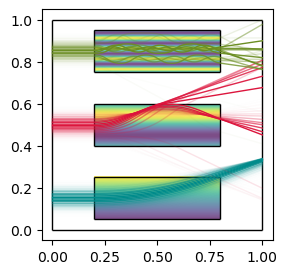

In [7]:
from ray_trace import GradientIndexRegion, GaussianBundle, OpticalSystem, trace_bundle
import matplotlib.pyplot as plt
import numpy as np

sys = OpticalSystem()
grins = []
bundles = []
for ind, period in enumerate((1, 0.2, 0.05)):
    center = np.array([0.5, 0.15 + ind*0.35])
    # NOTE: additional index_func argumnets must be passed directly to 
    # GradientIndexRegion. 
    def index_func(point, func_center, func_period):
        import numpy as np
        r = np.array([0.0, 1.0])/np.sqrt(1) @ (point - func_center)
        return 1.0 + 0.1*np.sin(2*np.pi*r/func_period)
    grin = GradientIndexRegion(index_func=index_func,
                               step_size=0.01,
                               meshspec=[[0.2, 0.8, 100],[center[1]-0.1, center[1]+0.1, 100]],
                               func_center=center,
                               func_period=period)
    bundle = GaussianBundle(waist=0.05, 
                            center=[0.0, center[1]], 
                            number = 30,
                            direction=[1.0, 0.0], 
                            dither=True)

    grins.append(grin)
    bundles.append(bundle)
    #center[1] += 0.35


sys.add_element(grins)
for bundle in bundles:
    trace_bundle(sys, bundle)


# Periodicity of index variations can have a large impact on 
# ray trace outcomes.
fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
colors = ("darkcyan", "crimson", "olivedrab")
for bundle, color in zip(bundles, colors):
    bundle.plot(ax, color=color, lw=1)

# SphericalSource

`SphericalSource` provides methods for converting a temporal profile into a spherical traveling wave for use in a `GradientIndexRegion`. A `SphericaslSource` is defined by a `reference_amplitude` $A_0$, `reference_distance` $r_0$, `epicenter` $\mathbf{c}$, and sound speed $c_0$ (default 343). The method `make_index_func` takes a `temporal_profile` $f(t)$ and returs an `index_func` $n(\mathbf{r}) = n_0 + \frac{A_0 r_0 }{ |\mathbf{r} - \mathbf{c}|} f\left (t -  \frac{|\mathbf{r} - \mathbf{c}|}{c_0} \right )$. Similarly, the method `make_grad_index_func` takes a `temporal_profile` $f(t)$ and its `temporal_derivative` $\dot{f}(t)$ and returns an `grad_index_func` $\nabla n(\mathbf{r}) = -\frac{A_0 r_0}{c_0}\frac{\mathbf{r} - \mathbf{c}}{|\mathbf{r} - \mathbf{c}|^3}\left [ f \left (t -  \frac{|\mathbf{r} - \mathbf{c}|}{c_0} \right ) + |\mathbf{r} - \mathbf{c}| \dot{f} \left (t -  \frac{ |\mathbf{r} - \mathbf{c}|}{c_0} \right ) \right ]$.

Traced 20 rays in 0.216 s using 32 cores


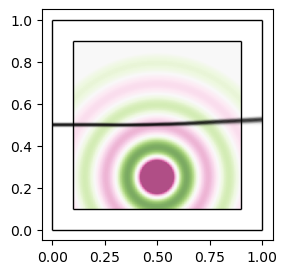

In [8]:
from ray_trace import SphericalSource, GradientIndexRegion, GaussianBundle, OpticalSystem, trace_bundle
import matplotlib.pyplot as plt
import numpy as np

def temporal_profile(time, frequency):
    import numpy as np
    return np.sin(2*np.pi*frequency*time)

def temporal_derivative(time, frequency):
    import numpy as np
    return 2*np.pi*frequency * np.cos(2*np.pi*frequency*time)

source = SphericalSource(temporal_profile=temporal_profile,
                         temporal_derivative=temporal_derivative,
                         reference_amplitude=0.01,
                         reference_distance=0.25,
                         epicenter=[0.5, 0.25],
                         sound_speed=1.0)


grin = GradientIndexRegion(index_func=source.index_func,
                           grad_index_func=source.grad_index_func,
                           time=0.6, 
                           frequency=5,
                           step_size=0.01,
                           meshspec=[[0.1, 0.9, 100],[0.1, 0.9, 100]],
                           )
bundle = GaussianBundle(waist=0.01, 
                        center=[0.0, 0.5], 
                        number = 20,
                        direction=[1.0, 0.0], 
                        dither=False)

sys = OpticalSystem()
sys.add_element(grin)
trace_bundle(sys, bundle)


fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax, 
         cmap='PiYG', 
         vmin=1-2*source.reference_amplitude, 
         vmax=1+2*source.reference_amplitude)
bundle.plot(ax, color="k", mec="k", mfc="none", mew=0.5, lw=0.5, ms=2)

# Detector

The `Detector` class defines a finite one-dimensional line used to intercept rays. Rays hitting a detector may be coarse-grain analyzed by pixelating the detector into equal-sized bins. The pixel-total power and pixel-average optical path length of the rays hitting the detector are used to infer an intensity pattern at the per-pixel level. Geometrically, a detector is defined like a `Mirror` in terms of its `length`, `center`, and `angle`. The method `detect_bundle` may then be called on a traced ray bundle with argument `Npixels` to return the relative pixel coordinates (measured from the center of the detector), complex `ampltitudes` sqrt(pixel_power) exp(-i pixel_phase), pixel `counts`, and pixel `phases`. Each time this method is called, the results are appended to an internal list `counts`, `amplitudes`, `phases`, `optical_path_lengths`, and `bundle_powers`. The method `reset` reinitializes the internal lists to be empty. The method `detect_bundles` can be used for multi-bundle interference. 

Traced 2000 rays in 0.323 s using 32 cores


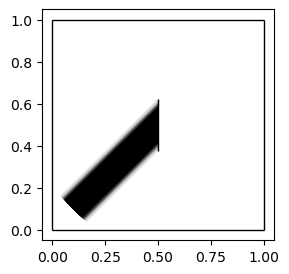

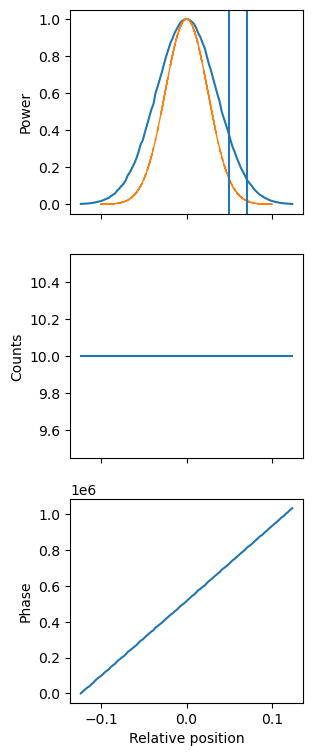

In [4]:
from ray_trace import Detector, GaussianBundle, OpticalSystem, trace_bundle
import matplotlib.pyplot as plt
import numpy as np

sys = OpticalSystem()
detector = Detector(length=0.25, center=[0.5, 0.5], angle=np.pi/2)
bundle = GaussianBundle(waist=0.05, 
                        center=[0.1, 0.1], 
                        number = 2000,
                        direction=[1,1.], 
                        dither=True)

sys.add_element(detector)
trace_bundle(sys, bundle)

fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
bundle.plot(ax, lw=0.5, color="k")
plt.show()

detector.detect(bundle, Npixels=100, fix_count=10)

fig, axs = plt.subplots(3, 1, figsize=(3,9), sharex=True)

detector.plot_result(axs)
axs[0].plot(bundle.relative_origins, 
            bundle.powers/np.max(bundle.powers),
            lw=1)
axs[0].axvline(bundle.waist)
axs[0].axvline(np.sqrt(2)*bundle.waist)

In [24]:
from ray_trace import Detector, GaussianBundle, OpticalSystem, trace_bundle
import matplotlib.pyplot as plt
import numpy as np

detector = Detector(length=0.01, center=[0.5, 0.5], angle=np.pi/2)
bundle1 = GaussianBundle(waist=0.00005, 
                        center=[0.1, 0.5], 
                        number = 10000,
                        direction=[1, 0], 
                        dither=True)
bundle2 = GaussianBundle(waist=0.00005, 
                        center=[0.1, 0.5], 
                        number = 10000,
                        direction=[1, 0], 
                        dither=True)

bundles = [bundle1, bundle2]
sys = OpticalSystem()
sys.add_element(detector)
for bundle in bundles:
    trace_bundle(sys, bundle)


Traced 10000 rays in 1.41 s using 32 cores
Traced 10000 rays in 1.31 s using 32 cores


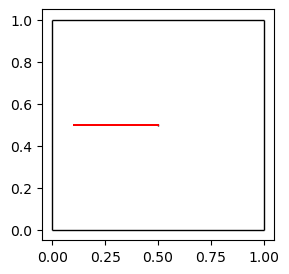

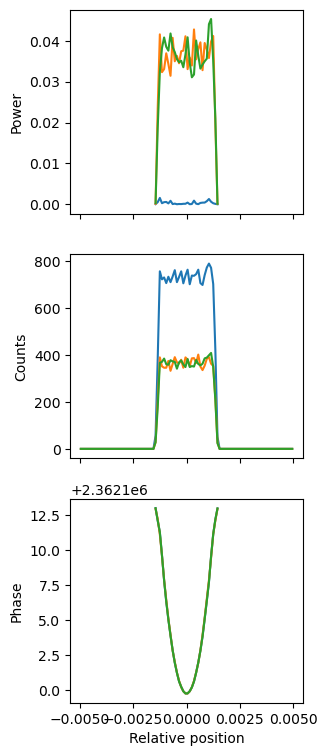

In [27]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
sys.plot(ax)
for bundle, color in zip(bundles, ["k", "r"]):
    bundle.plot(ax, lw=0.5, color=color)
plt.show()

detector.detect_bundles(bundles=bundles, 
                        Npixels=100, 
                        fix_count=500,
                        relative_phase=np.pi)
fig, axs = plt.subplots(3, 1, figsize=(3,9), sharex=True)
detector.plot_result(axs)
detector.plot_result(axs, bundle_index=0)
detector.plot_result(axs, bundle_index=1)

In [4]:
detector.phases

[array([2830859.84733898, 2857972.63093011, 2883978.4695339 ,
        2911114.67551861, 2935922.53241299, 2962024.63921107,
        2988988.47325482, 3014736.17356736, 3040038.4224762 ,
        3064563.75450324, 3090860.01341885, 3117641.85898154,
        3147887.97728993, 3169985.89183386, 3195341.95703346,
        3222369.10781127, 3249505.66512555, 3276449.93937078,
        3300748.15229185, 3328738.94944061, 3355548.15545978,
        3379669.02177079, 3404966.69545355, 3431149.55953263,
        3459252.51494647, 3484434.65964485, 3512027.23287307,
        3536290.57373205, 3561878.530766  , 3588327.77216311,
        3615468.54272989, 3638214.89667507, 3667458.33126026,
        3693675.9795419 , 3721603.77905056, 3746335.09669635,
        3770374.96610009, 3797220.24950736, 3823281.52023146,
        3850180.32273077]),
 array([3849357.29409516, 3822707.24937629, 3799250.44752211,
        3771626.37670147, 3743777.37247595, 3719180.86155317,
        3694595.06008907, 3667447.07946778